In [22]:
# 0. INSTALL
!pip install bayesian-optimization
!pip install yfinance --upgrade

# 1. IMPORT LIBRARIES
import warnings
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

plt.style.use("seaborn-v0_8")

In [24]:

# 1.1 CONFIG
USE_LOG_PRICES = True           # log prices for cointegration / spread
TRANSACTION_COST = 0.0005       # cost per unit change in position
ANNUALIZATION = 252             # daily data
USE_EMA = False                 # EMA vs rolling window for z-score
EMA_SPAN_MULTIPLIER = 1.0



In [25]:

# 2. DATA & COINTEGRATION HELPERS

def download_and_split_data(tickers, start_date, end_date, train_end):
    """Download data from yfinance and split into train/test."""
    print("Downloading")
    try:
        all_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

        if all_data.empty:
            raise ValueError("No data downloaded.")

        if isinstance(all_data.columns, pd.MultiIndex):
            if 'Adj Close' in all_data.columns.get_level_values(0):
                prices = all_data['Adj Close']
            elif 'Close' in all_data.columns.get_level_values(0):
                print("Warning: 'Adj Close' missing. Using 'Close'.")
                prices = all_data['Close']
            else:
                raise KeyError("Could not identify Price columns in MultiIndex.")
        else:
            if "Adj Close" in all_data.columns:
                prices = all_data["Adj Close"]
            elif "Close" in all_data.columns:
                prices = all_data["Close"]
            else:
                raise KeyError("No price column found.")

        prices = prices.dropna()
        if prices.empty:
            raise ValueError("All rows dropped due to NaNs.")

    except Exception as e:
        print(f"Error processing data: {e}")
        return None, None

    train_prices = prices.loc[:train_end]
    test_prices = prices.loc[pd.to_datetime(train_end) + pd.Timedelta(days=1):]

    if train_prices.empty or test_prices.empty:
        print("Train or test set is empty. Adjust split date.")
        return None, None

    print(f"Training rows: {train_prices.shape[0]}, Test rows: {test_prices.shape[0]}")
    return train_prices, test_prices


def prepare_price_matrix(prices: pd.DataFrame) -> pd.DataFrame:
    return np.log(prices) if USE_LOG_PRICES else prices


def find_cointegration_vector(data: pd.DataFrame):
    """Johansen cointegration; return normalized eigenvector."""
    print("\nFinding cointegration vector (Johansen)...")
    try:
        result = coint_johansen(data, det_order=0, k_ar_diff=1)
        weights = result.evec[:, 0]
        weights = weights / weights[0]
    except Exception as e:
        print(f"Cointegration test failed: {e}")
        print("Fallback: equal weights.")
        weights = np.ones(data.shape[1]) / data.shape[1]
    return weights


def calculate_spread(data: pd.DataFrame, weights: np.ndarray) -> pd.Series:
    return (data * weights).sum(axis=1)


In [26]:
# 3. OU / AR(1) DIAGNOSTICS

def estimate_ou_params(spread: pd.Series):
    """
    Fit AR(1): X_t = c + phi X_{t-1} + eps, then map to OU params.
    """
    x = spread.dropna()
    if len(x) < 30:
        return np.nan, np.nan, np.nan, np.nan

    x_lag = x.shift(1).dropna()
    y = x.loc[x_lag.index]

    A = np.column_stack([x_lag.values, np.ones(len(x_lag))])
    try:
        coef, _, _, _ = np.linalg.lstsq(A, y.values, rcond=None)
    except Exception:
        return np.nan, np.nan, np.nan, np.nan

    phi = coef[0]
    c = coef[1]

    # If phi is approx 1, it's a random walk
    if phi <= 0 or phi >= 0.999:
        return phi, np.nan, np.nan, np.nan

    kappa = -np.log(phi)
    mu = c / (1 - phi) if (1 - phi) != 0 else np.nan
    half_life = np.log(2) / kappa if kappa > 0 else np.nan
    return phi, kappa, mu, half_life


def print_ou_summary(name: str, spread: pd.Series):
    phi, kappa, mu, half_life = estimate_ou_params(spread)
    print(f"\nOU diagnostics for {name}:")
    print(f"  phi        : {phi:.4f}" if not np.isnan(phi) else "  phi        : NaN")
    print(f"  kappa      : {kappa:.4f}" if not np.isnan(kappa) else "  kappa      : NaN")
    print(f"  mu         : {mu:.4f}" if not np.isnan(mu) else "  mu         : NaN")
    print(f"  half-life  : {half_life:.2f} days" if not np.isnan(half_life) else "  half-life  : NaN")

    if not np.isnan(half_life):
        if half_life < 3:
            comment = "Very fast mean reversion (possible noise)."
        elif half_life < 60:
            comment = "Reasonable mean reversion horizon."
        else:
            comment = "Slow mean reversion (hard to trade)."
        print("  note       :", comment)


In [27]:

# 4. PERFORMANCE & Z-SCORE

def compute_performance_stats(r: pd.Series, annualization_factor: int = ANNUALIZATION):
    r = r.dropna()
    if r.empty:
        return {
            "sharpe": -1.0, "max_drawdown": 0.0, "total_return": 0.0,
            "volatility": 0.0, "win_rate": 0.0
        }

    mean_ret = r.mean()
    std_ret = r.std()

    if std_ret == 0 or np.isnan(std_ret):
        sharpe = -1.0
    else:
        sharpe = (mean_ret / std_ret) * np.sqrt(annualization_factor)

    eq = (1 + r).cumprod()
    running_max = eq.cummax()
    dd = eq / running_max - 1
    max_dd = dd.min() if not dd.empty else 0.0

    vol = std_ret * np.sqrt(annualization_factor) if not np.isnan(std_ret) else 0.0
    win_rate = (r > 0).mean()
    cum_return = (1 + r).prod() - 1

    return {
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "total_return": cum_return,
        "volatility": vol,
        "win_rate": win_rate,
    }


def compute_zscore(series: pd.Series, lookback: int) -> pd.Series:
    if USE_EMA:
        span = max(2, int(EMA_SPAN_MULTIPLIER * lookback))
        m = series.ewm(span=span, adjust=False).mean()
        v = (series - m) ** 2
        s = np.sqrt(v.ewm(span=span, adjust=False).mean())
        s = s.replace(0, np.nan).ffill().bfill()
        z = (series - m) / s
    else:
        m = series.rolling(window=lookback).mean()
        s = series.rolling(window=lookback).std()
        s = s.replace(0, np.nan).ffill().bfill()
        z = (series - m) / s
    return z.dropna()

In [28]:
# 5. CORE STRATEGY LOGIC

def run_strategy(spread: pd.Series,
                 lookback: int,
                 entry_z: float,
                 exit_z: float,
                 transaction_cost: float = TRANSACTION_COST,
                 annualization_factor: int = ANNUALIZATION):
    lookback = int(round(lookback))
    if lookback <= 5:
        return -1.0, None, None
    if exit_z >= entry_z or entry_z <= 0:
        return -1.0, None, None

    z = compute_zscore(spread, lookback)
    if z.empty:
        return -1.0, None, None

    # SIGNAL GENERATION
    pos = pd.Series(0.0, index=z.index)
    pos[z > entry_z] = -1.0  # Sell Spread
    pos[z < -entry_z] = 1.0  # Buy Spread
    # Exit zone
    pos[(z < exit_z) & (z > -exit_z)] = 0.0

    # Forward fill positions (hold until signal changes)
    pos = pos.ffill().fillna(0)

    # RETURNS
    # Shift position by 1 because we trade at Close, realizing return on Next Close
    spread_ret = spread.pct_change()
    gross_ret = pos.shift(1) * spread_ret

    # Transaction costs (on position changes)
    dpos = pos.diff().fillna(0).abs()
    cost = dpos * transaction_cost
    net_ret = (gross_ret - cost).dropna()

    if net_ret.std() == 0 or np.isnan(net_ret.std()):
        return -1.0, None, None

    stats = compute_performance_stats(net_ret, annualization_factor)
    sharpe = stats["sharpe"]

    if np.isinf(sharpe) or np.isnan(sharpe):
        return -1.0, None, None

    equity = (1 + net_ret).cumprod()
    return sharpe, stats, equity


def backtest_wrapper(spread: pd.Series, lookback: float, entry_z: float, exit_z: float):
    """Wrapper for Bayesian Optimization (returns scalar Sharpe)."""
    sharpe, stats, _ = run_strategy(
        spread,
        lookback,
        entry_z,
        exit_z,
        transaction_cost=TRANSACTION_COST,
        annualization_factor=ANNUALIZATION,
    )
    # Return -10 if invalid to discourage optimizer
    return -10.0 if stats is None else sharpe



In [29]:
# 6. VISUALIZATION HELPERS

def shade_position_regions(ax, positions: pd.Series):
    """Light shading for long/short regimes."""
    in_pos = False
    start = None
    sign = 0
    for t, p in positions.items():
        s = np.sign(p)
        if not in_pos and s != 0:
            in_pos = True
            start = t
            sign = s
        elif in_pos and (s == 0 or s != sign):
            color = "green" if sign > 0 else "red"
            ax.axvspan(start, t, alpha=0.1, color=color)
            in_pos = False
    if in_pos and start is not None:
        color = "green" if sign > 0 else "red"
        ax.axvspan(start, positions.index[-1], alpha=0.1, color=color)


def plot_spread(train_spread: pd.Series, test_spread: pd.Series):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(train_spread, label="Train Spread", linewidth=1.5, alpha=0.8)
    ax.plot(test_spread, label="Test Spread", linewidth=1.5, alpha=0.8)
    ax.axvline(train_spread.index[-1], color="black", linestyle="--", label="Split")
    ax.set_title("Cointegrated Spread (Train vs Test)")
    ax.legend()
    plt.show()


def plot_equity_with_drawdown(equity: pd.Series, title: str):
    equity = equity.dropna()
    if equity.empty: return
    dd = equity / equity.cummax() - 1

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(equity, label="Equity", color='blue')
    ax1.set_ylabel("Equity")
    ax1.set_title(title)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.fill_between(dd.index, dd, 0, color='red', alpha=0.2, label="Drawdown")
    ax2.set_ylabel("Drawdown")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")
    plt.show()


def plot_final_strategy(spread: pd.Series, lookback: int, entry_z: float, exit_z: float, title: str):
    z = compute_zscore(spread, lookback)
    pos = pd.Series(0.0, index=z.index)
    pos[z > entry_z] = -1
    pos[z < -entry_z] = 1
    pos[(z < exit_z) & (z > -exit_z)] = 0
    pos = pos.ffill().fillna(0)

    spread_ret = spread.pct_change()
    gross = pos.shift(1) * spread_ret
    cost = pos.diff().abs() * TRANSACTION_COST
    net = (gross - cost).dropna()
    equity = (1 + net).cumprod()

    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={"height_ratios": [1, 1, 1]})

    # 1. Spread
    axes[0].plot(spread, color='orange', label='Spread')
    shade_position_regions(axes[0], pos)
    axes[0].set_title(f"{title} - Spread & Positions")
    axes[0].legend()

    # 2. Z-Score
    axes[1].plot(z, color='blue', label='Z-Score', alpha=0.7)
    axes[1].axhline(entry_z, color='red', linestyle='--', label=f'Short (+{entry_z:.2f})')
    axes[1].axhline(-entry_z, color='green', linestyle='--', label=f'Long (-{entry_z:.2f})')
    axes[1].axhline(exit_z, color='grey', linestyle=':', label='Exit')
    axes[1].axhline(-exit_z, color='grey', linestyle=':')
    axes[1].set_title("Z-Score Logic")
    axes[1].legend(loc='upper right')

    # 3. Equity
    axes[2].plot(equity, color='purple', label='Equity Curve')
    axes[2].set_title("Strategy Performance")
    axes[2].legend()

    plt.tight_layout()
    plt.show()


#   CONFIDENCE VISUALS

def _fit_ar1(series: pd.Series):
    """Helper: fit AR(1) and return phi, c, sigma_eps."""
    x = series.dropna()
    if len(x) < 30: return np.nan, np.nan, np.nan
    x_lag = x.shift(1).dropna()
    y = x.loc[x_lag.index]

    # Linear Regression: y = phi*x_lag + c
    A = np.column_stack([x_lag.values, np.ones(len(x_lag))])
    coef, _, _, _ = np.linalg.lstsq(A, y.values, rcond=None)
    phi, c = coef

    # Calculate Residuals & Std Dev
    resid = y.values - (phi * x_lag.values + c)
    sigma = resid.std(ddof=1)
    return phi, c, sigma

def plot_ou_forecast(spread: pd.Series, window: int = 252, horizon: int = 20):
    """
    Shows the Mean Reversion Forecast with Confidence Bands.
    """


    x = spread.dropna()
    if len(x) < 50:
        print("Not enough data for forecast.")
        return

    # Use recent window to fit params
    x_win = x.iloc[-window:]
    phi, c, sigma_eps = _fit_ar1(x_win)

    if np.isnan(phi): return

    # Long run mean
    mu = c / (1 - phi) if (1 - phi) != 0 else x_win.mean()
    last_val = x_win.iloc[-1]

    # Forecast steps
    steps = np.arange(1, horizon + 1)

    # Expected Path: E[x_t+h] = mu + phi^h * (x_t - mu)
    forecast = mu + phi**steps * (last_val - mu)

    # Variance of forecast: Var_h = sigma^2 * (1 - phi^2h) / (1 - phi^2)
    # Clamp phi to avoid division by zero if random walk
    phi_safe = min(0.999, abs(phi))
    var_h = sigma_eps**2 * (1 - phi_safe**(2 * steps)) / (1 - phi_safe**2)
    std_h = np.sqrt(var_h)


    last_date = x_win.index[-1]
    future_dates = pd.date_range(start=last_date, periods=horizon + 1, freq="B")[1:]

    fig, ax = plt.subplots(figsize=(10, 6))


    ax.plot(x_win.index[-50:], x_win.values[-50:], label="Recent Spread", color="black")


    ax.plot(future_dates, forecast, label="OU Forecast", color="blue", linestyle="--")


    ax.fill_between(future_dates, forecast - std_h, forecast + std_h,
                    color='blue', alpha=0.2, label="1 Sigma (68%)")
    ax.fill_between(future_dates, forecast - 1.96*std_h, forecast + 1.96*std_h,
                    color='blue', alpha=0.1, label="2 Sigma (95%)")

    ax.axhline(mu, color='grey', linestyle=':', label='Long-Run Mean')
    ax.set_title(f"Mean Reversion Forecast (Horizon: {horizon} days)")
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.show()

def plot_residual_hist(spread: pd.Series, window: int = 252):
    """
    Shows if the spread behaves like a normal distribution (Gaussian).
    """
    x_win = spread.dropna().iloc[-window:]
    phi, c, sigma_eps = _fit_ar1(x_win)

    if np.isnan(phi): return

    x_lag = x_win.shift(1).dropna()
    y = x_win.loc[x_lag.index]
    resid = y.values - (phi * x_lag.values + c)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(resid, bins=30, density=True, alpha=0.6, color='grey', label='Residuals')


    mu, std = 0, sigma_eps
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std)**2)
    ax.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

    ax.set_title("Model Fit: Residuals vs Normal Distribution")
    ax.legend()
    plt.show()


In [30]:
# 7. TRADE LOGGING

def build_trade_log(spread: pd.Series, lookback: int, entry_z: float, exit_z: float) -> pd.DataFrame:
    z = compute_zscore(spread, lookback)
    pos = pd.Series(0.0, index=z.index)
    pos[z > entry_z] = -1
    pos[z < -entry_z] = 1
    pos[(z < exit_z) & (z > -exit_z)] = 0
    pos = pos.ffill().fillna(0)

    spread_ret = spread.pct_change()
    trade_ret = (pos.shift(1) * spread_ret).fillna(0)
    costs = pos.diff().abs() * TRANSACTION_COST
    net_ret = trade_ret - costs

    trades = []
    in_trade = False
    pnl = 0.0
    days = 0
    entry_idx = None
    direction = 0

    for i in range(len(pos)):
        p = pos.iloc[i]
        dt = pos.index[i]
        if not in_trade and p != 0:
            in_trade = True
            entry_idx = dt
            direction = p
            pnl = 0.0
            days = 0

        if in_trade:
            pnl += net_ret.iloc[i]
            days += 1

            if p == 0:
                trades.append({
                    'Entry': entry_idx,
                    'Exit': dt,
                    'Type': 'Long' if direction > 0 else 'Short',
                    'PnL': pnl,
                    'Days': days
                })
                in_trade = False

    return pd.DataFrame(trades)

def summarize_trade_log(name: str, trades: pd.DataFrame):
    if trades.empty:
        print(f"\n[{name}] No trades generated.")
        return

    print(f"\n[{name}] Trade Analysis:")
    print(f"  Count:       {len(trades)}")
    print(f"  Win Rate:    {(trades['PnL'] > 0).mean():.1%}")
    print(f"  Avg PnL:     {trades['PnL'].mean():.2%}")
    print(f"  Avg Holding: {trades['Days'].mean():.1f} days")


Downloading
Training rows: 1511, Test rows: 753

Finding cointegration vector (Johansen)...
Cointegration weights: [('JPM', np.float64(1.0)), ('GS', np.float64(-0.051)), ('MS', np.float64(-0.494)), ('C', np.float64(-0.972)), ('BAC', np.float64(0.19))]

OU diagnostics for train spread:
  phi        : 0.9813
  kappa      : 0.0189
  mu         : -3.2952
  half-life  : 36.65 days
  note       : Reasonable mean reversion horizon.


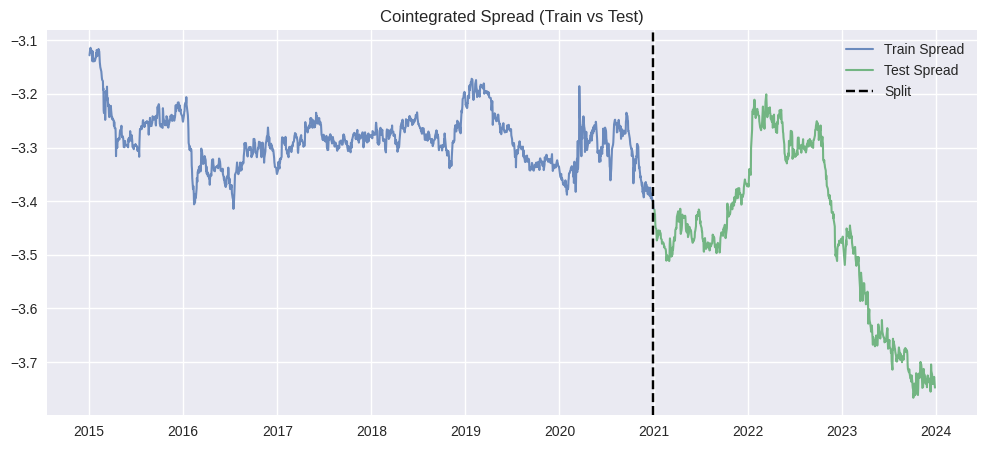


Running Bayesian Optimization (Please wait)...

Best Training Sharpe: 0.0038
Optimal Params: Lookback=100, Entry=3.50, Exit=1.50

--- Validating on Test Data ---

Test Stats:
  sharpe: -0.8792
  max_drawdown: -0.0010
  total_return: -0.0010
  volatility: 0.0004
  win_rate: 0.0000

[Train] Trade Analysis:
  Count:       3
  Win Rate:    0.0%
  Avg PnL:     0.00%
  Avg Holding: 5.0 days

[Test] Trade Analysis:
  Count:       1
  Win Rate:    0.0%
  Avg PnL:     0.00%
  Avg Holding: 2.0 days


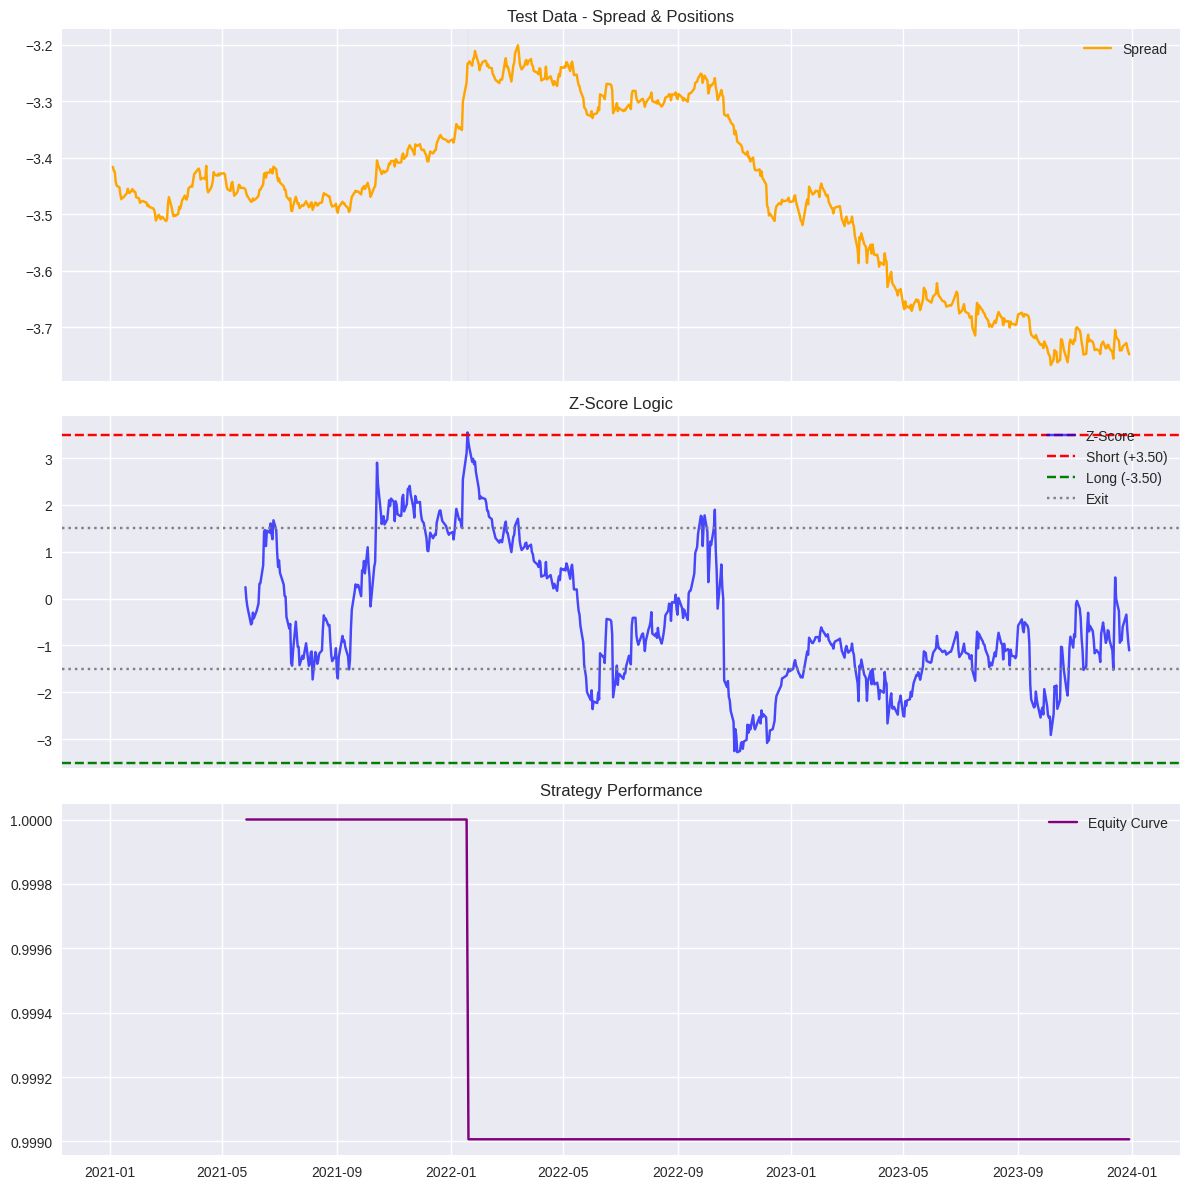

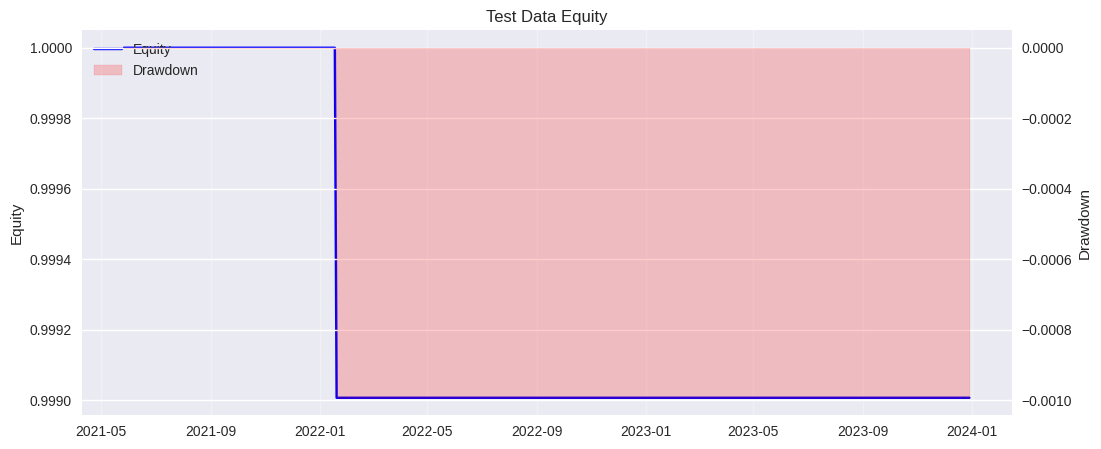


Generating Forecast Confidence & Residuals...


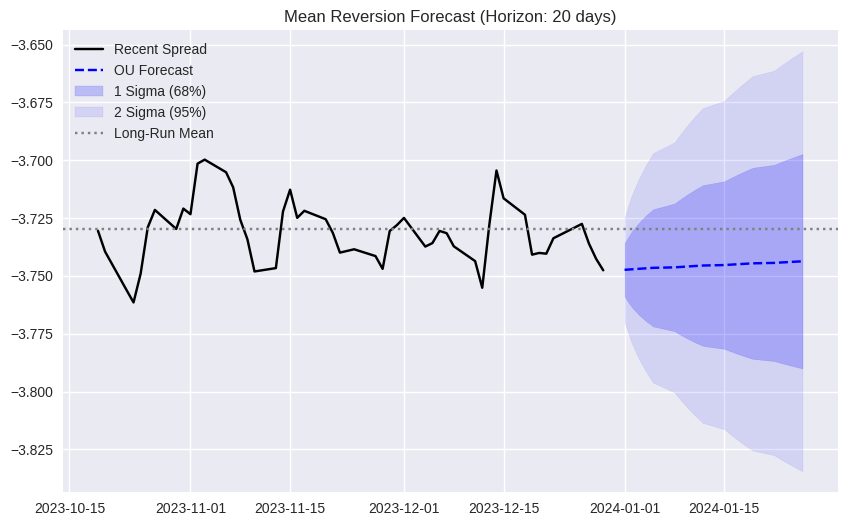

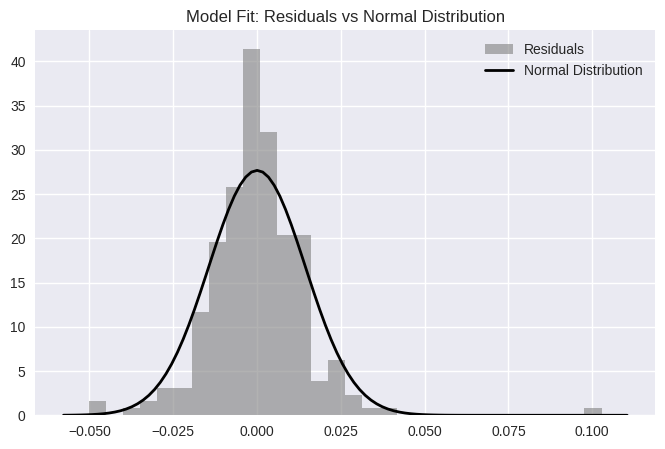

In [32]:
# 8. MAIN

def main():
    tickers = ["JPM", "GS", "MS", "C", "BAC"]
    start = "2015-01-01"
    end = "2023-12-31"
    train_end = "2020-12-31"

    warnings.filterwarnings("ignore")

    # 1. Data
    train_prices, test_prices = download_and_split_data(tickers, start, end, train_end)
    if train_prices is None: return

    train_mat = prepare_price_matrix(train_prices)
    test_mat = prepare_price_matrix(test_prices)

    # 2. Cointegration
    weights = find_cointegration_vector(train_mat)
    print("Cointegration weights:", list(zip(tickers, np.round(weights, 3))))

    train_spread = calculate_spread(train_mat, weights)
    test_spread = calculate_spread(test_mat, weights)

    print_ou_summary("train spread", train_spread)
    plot_spread(train_spread, test_spread)

    # 3. Optimization
    def objective(lookback, entry_z, exit_z):
        return backtest_wrapper(train_spread, lookback, entry_z, exit_z)

    bounds = { "lookback": (10, 100), "entry_z": (1.0, 3.5), "exit_z": (0.0, 1.5) }

    optimizer = BayesianOptimization(f=objective, pbounds=bounds, random_state=42, verbose=0)

    print("\nRunning Bayesian Optimization (Please wait)...")
    optimizer.maximize(init_points=5, n_iter=20)

    # Even if results are bad, we want to see the charts to know WHY.

    best = optimizer.max["params"]
    print(f"\nBest Training Sharpe: {optimizer.max['target']:.4f}")

    lookback_opt = int(round(best["lookback"]))
    entry_opt = best["entry_z"]
    exit_opt = best["exit_z"]

    # Sanity check Exit must be tighter than Entry
    if exit_opt >= entry_opt: exit_opt = entry_opt / 2.0

    print(f"Optimal Params: Lookback={lookback_opt}, Entry={entry_opt:.2f}, Exit={exit_opt:.2f}")

    print("\n--- Validating on Test Data ---")
    test_sharpe, test_stats, test_equity = run_strategy(
        test_spread, lookback_opt, entry_opt, exit_opt
    )

    # Also run on train to see equity curve there
    _, _, train_equity = run_strategy(
        train_spread, lookback_opt, entry_opt, exit_opt
    )

    print("\nTest Stats:")
    for k, v in test_stats.items():
        print(f"  {k}: {v:.4f}")

    # Trade Logs
    train_trades = build_trade_log(train_spread, lookback_opt, entry_opt, exit_opt)
    test_trades = build_trade_log(test_spread, lookback_opt, entry_opt, exit_opt)
    summarize_trade_log("Train", train_trades)
    summarize_trade_log("Test", test_trades)

    # Plots

    plot_final_strategy(test_spread, lookback_opt, entry_opt, exit_opt, "Test Data")
    plot_equity_with_drawdown(test_equity, "Test Data Equity")

    # CONFIDENCE GRAPHS
    print("\nGenerating Forecast Confidence & Residuals...")
    plot_ou_forecast(test_spread, window=252, horizon=20)
    plot_residual_hist(train_spread, window=252)


if __name__ == "__main__":
    main()